In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import glob, os, csv

from langdetect import detect

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import CoherenceModel

from pprint import pprint

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'javascript', 'onion', 'site', 'com'])

from bs4 import BeautifulSoup

# import pyLDAvis
# import pyLDAvis.gensim

import ast
from collections import Counter
from operator import add
from wordcloud import WordCloud

# import stanza
# # stanza.download('en')
# nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma')

from sklearn.model_selection import train_test_split
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [2]:
# Preprocessing

In [3]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text))

def preprocess(sentences):
    result = []
    
    for sent in sentences:
        lemmas = []
        # tokenize
        tokens = gensim.utils.simple_preprocess(sent)
        for token in tokens:
            lemma = lemmatize_stemming(token)
            # remove stopwords
            if lemma not in stop_words:
                lemmas.append(lemma)
        # POS tagging
        nltk_tagged = nltk.pos_tag(lemmas)
        for word, tag in nltk_tagged:
#             result.append(word)
            # only keep nouns
            if tag.startswith('N'):
                result.append(word)
    return result

In [4]:
def language_detect(ls):
    text = ' '.join(ls)
    result = detect(text)
    return result

In [5]:
df_labelled = pd.read_csv('../data/trainset_combined.csv')
df_unlabelled = pd.read_csv('../data/testset.csv')
df_labelled.drop(columns='Unnamed: 0', inplace=True)
df_unlabelled.drop(columns='Unnamed: 0', inplace=True)
# convert the string representation of a list into a list
df_labelled['body_text'] = df_labelled['body_text'].apply(ast.literal_eval)
df_labelled['body_token'] = df_labelled['body_token'].apply(ast.literal_eval)
df_labelled['main_class'] = df_labelled['main_class'].apply(lambda x: x.strip())
df_labelled['new_class'] = df_labelled['new_class'].apply(lambda x: x.strip())

df_unlabelled['body_text'] = df_unlabelled['body_text'].apply(ast.literal_eval)
df_unlabelled['title'] = df_unlabelled['title'].apply(ast.literal_eval)
df_unlabelled['body_token'] = df_unlabelled['body_token'].apply(ast.literal_eval)
df_unlabelled['title_token'] = df_unlabelled['title_token'].apply(ast.literal_eval)

In [6]:
## Categories ##
# Market: Services or goods are offered for (crypto)currency
# Counterfeit: counterfeit credit cards, money, ID
# Cryptocurrency: bitcoins
# Weapons: firearms

In [7]:
# Dictionary of conversion of categories
conversion_dict = {
    'Counterfeit Credit-Cards': 'Counterfeit',
    'Counterfeit Money': 'Counterfeit',
    'Counterfeit Personal-Identification': 'Counterfeit',
    'Cryptocurrency': 'Cryptocurrency',
    'Drugs': 'Market',
    'Marketplace': 'Market',
    'Violence': 'Weapons'
}

In [8]:
# Labelled urls from DUTA dataset
df_labelled = df_labelled[df_labelled['new_class'].apply(lambda x: x in conversion_dict.keys())]
df_labelled['conv_class'] = df_labelled['new_class'].apply(lambda x: conversion_dict[x])
df_labelled

,url,title,body_text,main_class,sub_class,language,body_token,new_class,conv_class
1,u76xgym22s4adf55.onion,PayPal Master: Home,"[PayPal Master: Home, Contact us at: ppmaster@...",Counterfeit Credit-Cards,NaN,en,"[master, home, contact, ppmaster, deepdarkmail...",Counterfeit Credit-Cards,Counterfeit
2,2hftxvyft7dl3fk2.onion,Umbrella Escrow,"[Umbrella Escrow, Start new escrow, View exist...",Cryptocurrency,NaN,en,"[umbrella, escrow, escrow, view, escrow, instr...",Cryptocurrency,Cryptocurrency
3,elherbotsiddarol.onion,ElHerbolario,"[ElHerbolario, My Account, Blog, PGP, Sitemap,...",Drugs,Illegal,en,"[elherbolario, account, blog, pgp, sitemap, nb...",Drugs,Market
5,safebtck4qejiero.onion,SafePay BTC | Bitcoin Escrow Payment Service,"[SafePay BTC | Bitcoin Escrow Payment Service,...",Cryptocurrency,NaN,en,"[safepay, btc, bitcoin, payment, servic, trust...",Cryptocurrency,Cryptocurrency
7,pmew6znterjncr3l.onion,Pharmmaster - pills delivery,"[Pharmmaster - pills delivery, PHARMMASTER, PH...",Drugs,Illegal,no,"[pharmmast, pill, deliveri, pharmmast, pharm, ...",Drugs,Market
...,...,...,...,...,...,...,...,...,...
970,prepaid3jdde64ro.onion,Euphoric Oblivion,"[Euphoric Oblivion, Euphoric Oblivion, Home, A...",Counterfeit Credit-Cards,NaN,en,"[euphor, oblivion, euphor, oblivion, home, con...",Counterfeit Credit-Cards,Counterfeit
975,rso4hutlefirefqp.onion,EuCanna - First Class Cannabis Healthcare - Bu...,[EuCanna - First Class Cannabis Healthcare - B...,Drugs,Illegal,en,"[eucanna, class, cannabi, healthcar, weed, can...",Drugs,Market
976,ccvendorwepczh7c.onion,CC Vendor Quality,"[CC Vendor Quality, CC Vendor Quality, Home, A...",Counterfeit Credit-Cards,NaN,en,"[cc, vendor, qualiti, cc, vendor, qualiti, hom...",Counterfeit Credit-Cards,Counterfeit
981,aaaaa5r6ckox3y7s.onion,Money Master - MoneyGram - Moneybookers - West...,[Money Master - MoneyGram - Moneybookers - Wes...,Counterfeit Credit-Cards,NaN,en,"[money, master, moneygram, moneybook, union, g...",Counterfeit Credit-Cards,Counterfeit


In [9]:
# Unlabelled urls from the crawler
df_unlabelled

,cluster_name,domain,url,title,body_text,body_token,title_token,language
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en
...,...,...,...,...,...,...,...,...
1330,淡路島,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,[淡路島],"[淡路島, 淡路島 - コシニテ人びとへの手紙 -, 玉ねぎを育もう, Update, 20...","[淡路島, 淡路島, コシニテ人びとへの手紙, 玉ねぎを育もう, updat, scale,...",[淡路島],ja
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en
1332,茶马古道,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,[茶马古道],"[茶马古道, 茶马护盾已开启欢迎来到茶马古道，页面跳转中...]","[茶马古道, 茶马护盾已开启欢迎来到茶马古道, 页面跳转中]",[茶马古道],ko
1333,藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉,['6tert2z5hydswwvt'],['6tert2z5hydswwvt.onion'],[藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉],[藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉],"[犯罪者, 窃盗, 脅迫, たかり, 亘心綜合音楽事務所, 太眉]","[犯罪者, 窃盗, 脅迫, たかり, 亘心綜合音楽事務所, 太眉]",ko


In [10]:
# English labelled urls
df_labelled_eng = df_labelled[df_labelled['language'] == 'en']
df_labelled_eng

,url,title,body_text,main_class,sub_class,language,body_token,new_class,conv_class
1,u76xgym22s4adf55.onion,PayPal Master: Home,"[PayPal Master: Home, Contact us at: ppmaster@...",Counterfeit Credit-Cards,NaN,en,"[master, home, contact, ppmaster, deepdarkmail...",Counterfeit Credit-Cards,Counterfeit
2,2hftxvyft7dl3fk2.onion,Umbrella Escrow,"[Umbrella Escrow, Start new escrow, View exist...",Cryptocurrency,NaN,en,"[umbrella, escrow, escrow, view, escrow, instr...",Cryptocurrency,Cryptocurrency
3,elherbotsiddarol.onion,ElHerbolario,"[ElHerbolario, My Account, Blog, PGP, Sitemap,...",Drugs,Illegal,en,"[elherbolario, account, blog, pgp, sitemap, nb...",Drugs,Market
5,safebtck4qejiero.onion,SafePay BTC | Bitcoin Escrow Payment Service,"[SafePay BTC | Bitcoin Escrow Payment Service,...",Cryptocurrency,NaN,en,"[safepay, btc, bitcoin, payment, servic, trust...",Cryptocurrency,Cryptocurrency
13,smoker32pk4qt3mx.onion,Smokeables - Finest Organic Cannabis - Buy wee...,[Smokeables - Finest Organic Cannabis - Buy we...,Drugs,Illegal,en,"[smokeabl, organ, cannabi, bitcoin, web, shop,...",Drugs,Market
...,...,...,...,...,...,...,...,...,...
970,prepaid3jdde64ro.onion,Euphoric Oblivion,"[Euphoric Oblivion, Euphoric Oblivion, Home, A...",Counterfeit Credit-Cards,NaN,en,"[euphor, oblivion, euphor, oblivion, home, con...",Counterfeit Credit-Cards,Counterfeit
975,rso4hutlefirefqp.onion,EuCanna - First Class Cannabis Healthcare - Bu...,[EuCanna - First Class Cannabis Healthcare - B...,Drugs,Illegal,en,"[eucanna, class, cannabi, healthcar, weed, can...",Drugs,Market
976,ccvendorwepczh7c.onion,CC Vendor Quality,"[CC Vendor Quality, CC Vendor Quality, Home, A...",Counterfeit Credit-Cards,NaN,en,"[cc, vendor, qualiti, cc, vendor, qualiti, hom...",Counterfeit Credit-Cards,Counterfeit
981,aaaaa5r6ckox3y7s.onion,Money Master - MoneyGram - Moneybookers - West...,[Money Master - MoneyGram - Moneybookers - Wes...,Counterfeit Credit-Cards,NaN,en,"[money, master, moneygram, moneybook, union, g...",Counterfeit Credit-Cards,Counterfeit


In [11]:
# English unlabelled urls
df_unlabelled_eng = df_unlabelled[df_unlabelled['language'] == 'en']
df_unlabelled_eng

,cluster_name,domain,url,title,body_text,body_token,title_token,language
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en
...,...,...,...,...,...,...,...,...
1304,| TheYOSH.nl,['ctzzqqimlfamyhrc'],['ctzzqqimlfamyhrc.onion'],[| TheYOSH.nl],"[| TheYOSH.nl, Skip to main content, User acco...","[theyosh, nl, skip, content, user, account, me...","[theyosh, nl]",en
1321,✉ Guerrilla Mail on Tor,['grrmailb3fxpjbwm'],['grrmailb3fxpjbwm.onion'],[✉ Guerrilla Mail on Tor],"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...","[guerrilla, mail, tor]",en
1322,✔ Legit Carding Services ♛ Money Transfer Worl...,['greenegbqkyk3ois'],['greenegbqkyk3ois.onion'],[✔ Legit Carding Services ♛ Money Transfer Wor...,[✔ Legit Carding Services ♛ Money Transfer Wor...,"[card, servic, money, transfer, worldwid, webs...","[card, servic, money, transfer, worldwid, webs...",en
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en


In [12]:
# Show the tokens of websites in "Market" category
df_labelled_eng[df_labelled_eng['conv_class'] == 'Market']['body_token']

3      [elherbolario, account, blog, pgp, sitemap, nb...
13     [smokeabl, organ, cannabi, bitcoin, web, shop,...
14     [market, home, rule, panel, contact, u, click,...
22     [appl, store, buy, se, imac, ipad, macbook, ap...
39     [kamagra, bitcoin, origin, viagra, pill, price...
                             ...                        
921    [cleev, residenti, sale, let, websit, thi, lea...
953    [appl, store, buy, se, imac, ipad, macbook, ap...
957    [drug, store, darkweb, drug, supplier, speed, ...
964    [cannabisuk, wholesal, cannabi, supplier, orde...
975    [eucanna, class, cannabi, healthcar, weed, can...
Name: body_token, Length: 83, dtype: object

In [13]:
# Create Bag of Words dictionary
labelled_docs = df_labelled_eng['body_token']
bow_dictionary = gensim.corpora.Dictionary(labelled_docs)
bow = [bow_dictionary.doc2bow(doc) for doc in labelled_docs]
word_counts = [[(bow_dictionary[id], count) for id, count in line] for line in bow]

L_labelled = df_labelled_eng['conv_class']
C_labelled = []
for line in word_counts:
    C_labelled.append(dict(line))

In [14]:
# Matrix of BoW of labelled urls
# Each row represents a labelled url
C_labelled

[{'account': 19,
  'address': 1,
  'age': 1,
  'agre': 1,
  'ani': 1,
  'ask': 1,
  'author': 1,
  'avail': 2,
  'btc': 5,
  'busi': 1,
  'buyer': 1,
  'cart': 1,
  'cashout': 2,
  'catch': 4,
  'circumst': 1,
  'contact': 3,
  'control': 1,
  'copyright': 1,
  'cost': 4,
  'day': 1,
  'deal': 1,
  'deepdarkmail': 2,
  'disput': 1,
  'doe': 1,
  'email': 3,
  'enforc': 1,
  'eventu': 1,
  'friendli': 1,
  'fund': 12,
  'group': 1,
  'guarante': 1,
  'guy': 1,
  'hack': 2,
  'hacker': 2,
  'hand': 1,
  'hassl': 1,
  'help': 1,
  'home': 2,
  'hour': 4,
  'immedi': 4,
  'includ': 1,
  'incom': 1,
  'info': 1,
  'inform': 1,
  'knowledg': 1,
  'law': 1,
  'limit': 1,
  'line': 1,
  'master': 5,
  'method': 4,
  'money': 1,
  'month': 1,
  'navig': 1,
  'net': 3,
  'offer': 1,
  'ok': 1,
  'order': 1,
  'owner': 1,
  'pa': 1,
  'payment': 1,
  'paypal': 8,
  'phone': 1,
  'pleas': 1,
  'possibl': 1,
  'pp': 8,
  'ppmaster': 3,
  'premier': 1,
  'provid': 1,
  'question': 1,
  'receiv': 4,


In [15]:
# Encode C_labelled
dv = DictVectorizer(sparse=True)
X = dv.fit_transform(C_labelled)
print(X)

  (0, 35)	19.0
  (0, 61)	1.0
  (0, 104)	1.0
  (0, 111)	1.0
  (0, 200)	1.0
  (0, 288)	1.0
  (0, 332)	1.0
  (0, 342)	2.0
  (0, 648)	5.0
  (0, 675)	1.0
  (0, 680)	1.0
  (0, 764)	1.0
  (0, 777)	2.0
  (0, 785)	4.0
  (0, 908)	1.0
  (0, 1054)	3.0
  (0, 1064)	1.0
  (0, 1076)	1.0
  (0, 1087)	4.0
  (0, 1238)	1.0
  (0, 1250)	1.0
  (0, 1269)	2.0
  (0, 1385)	1.0
  (0, 1420)	1.0
  (0, 1620)	3.0
  :	:
  (246, 3470)	1.0
  (246, 3514)	1.0
  (246, 3581)	1.0
  (246, 3659)	1.0
  (246, 3684)	1.0
  (246, 3719)	2.0
  (246, 3747)	1.0
  (246, 3834)	1.0
  (246, 3883)	1.0
  (246, 3928)	1.0
  (246, 3942)	1.0
  (246, 3961)	1.0
  (246, 4105)	1.0
  (246, 4110)	1.0
  (246, 4438)	1.0
  (246, 4509)	1.0
  (246, 4526)	2.0
  (246, 4576)	1.0
  (246, 4725)	1.0
  (246, 4919)	1.0
  (246, 5000)	2.0
  (246, 5034)	1.0
  (246, 5203)	1.0
  (246, 5429)	1.0
  (246, 5451)	1.0


In [16]:
# List of unique labels
L_labelled = list(L_labelled)
label_set = set(L_labelled)
label_set

{'Counterfeit', 'Cryptocurrency', 'Market', 'Weapons'}

In [17]:
# Encode L_labelled as integers
le = preprocessing.LabelEncoder()
le.fit(L_labelled)
y = le.transform(L_labelled)
y

array([0, 1, 2, 1, 2, 2, 3, 3, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0,
       0, 2, 0, 1, 2, 0, 2, 3, 0, 2, 2, 2, 3, 2, 2, 0, 2, 2, 1, 1, 0, 1,
       2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 3,
       0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 1, 2, 2, 2, 1, 1, 0, 3, 2, 1,
       1, 3, 0, 0, 2, 0, 3, 0, 0, 2, 3, 0, 1, 0, 0, 1, 2, 3, 1, 0, 1, 2,
       1, 0, 2, 0, 0, 3, 1, 1, 0, 1, 1, 1, 3, 0, 0, 1, 0, 0, 2, 0, 1, 1,
       1, 2, 2, 1, 0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0,
       2, 1, 1, 0, 3, 1, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0,
       1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 2, 0, 2, 0, 1,
       0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 0,
       2, 0, 0, 0, 0, 2, 3, 2, 2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 2, 2, 0, 2,
       0, 2, 0, 0, 0])

In [18]:
# Compare models

In [19]:
# Convert lists of tokens into lists of strings
# Each row represents an url
labelled_docs = df_labelled_eng['body_token']
labelled_docs_string = labelled_docs.apply(lambda x: ' '.join(x))
labelled_size = labelled_docs_string.shape[0]
unlabelled_docs = df_unlabelled_eng['body_token']
unlabelled_docs_string = unlabelled_docs.apply(lambda x: ' '.join(x))
# Concatenate two series
docs_string = pd.concat([labelled_docs_string, unlabelled_docs_string], ignore_index=True)
docs_string

0       master home contact ppmaster deepdarkmail net ...
1       umbrella escrow escrow view escrow instruct se...
2       elherbolario account blog pgp sitemap nbspcart...
3       safepay btc bitcoin payment servic trust bitco...
4       smokeabl organ cannabi bitcoin web shop produc...
                              ...                        
1409    theyosh nl skip content user account menu log ...
1410    guerrilla mail tor dispos mail address email t...
1411    card servic money transfer worldwid websit pro...
1412    约伊兹的萌狼乡手札 menu 约伊兹的萌狼乡手札 more_vert ホロ 且被束缚在这块土...
1413    page admin cm articl onion tor browser onion s...
Name: body_token, Length: 1414, dtype: object

In [20]:
# Convert lists of strings into tf-idf vectors
tfidf_vect = TfidfVectorizer(strip_accents='ascii', stop_words='english', min_df=3)
C_tfidf = tfidf_vect.fit_transform(docs_string)

C_tfidf_labelled = C_tfidf[:labelled_size]
C_tfidf_unlabelled = C_tfidf[labelled_size:]

# Train test split
C_train, C_test, y_train, y_test = train_test_split(C_tfidf_labelled, y, random_state = 0)

In [21]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    SVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=5),
    XGBClassifier()]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, C_tfidf_labelled, L_labelled, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

print(cv_df.groupby('model_name').accuracy.mean())

model_name
KNeighborsClassifier      0.882939
LinearSVC                 0.919102
LogisticRegression        0.902939
MultinomialNB             0.821878
RandomForestClassifier    0.765224
SVC                       0.906857
XGBClassifier             0.895102
Name: accuracy, dtype: float64


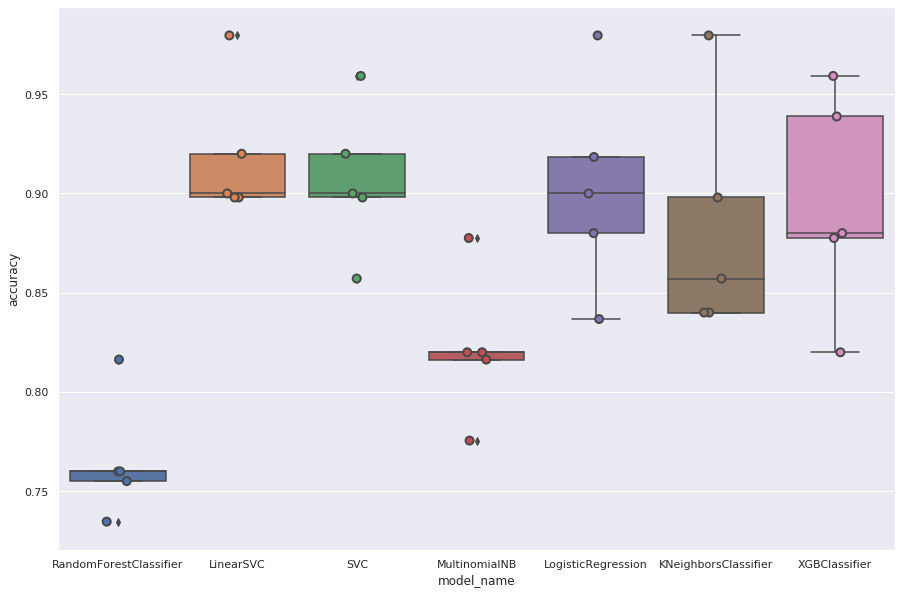

In [22]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [23]:
# Fit ensembled models and predict

In [24]:
# Fit a Linear SVC model
linearsvc = LinearSVC()
linearsvc.fit(C_train, y_train)
# Predict test set
y_predict_lsvc = linearsvc.predict(C_test)
# Print accuracy
print(accuracy_score(y_test, y_predict_lsvc))

0.8709677419354839


In [25]:
# Show scores for each category
print(classification_report(y_test, y_predict_lsvc, target_names=label_set))

                precision    recall  f1-score   support

       Weapons       1.00      0.83      0.90        23
        Market       1.00      0.85      0.92        13
Cryptocurrency       0.72      1.00      0.84        21
   Counterfeit       1.00      0.60      0.75         5

      accuracy                           0.87        62
     macro avg       0.93      0.82      0.85        62
  weighted avg       0.91      0.87      0.87        62



In [26]:
# Fit a Linear SVC model
svc = SVC()
svc.fit(C_train, y_train)
# Predict test set
y_predict_svc = svc.predict(C_test)
# Print accuracy
print(accuracy_score(y_test, y_predict_svc))

0.8548387096774194


In [27]:
# Show scores for each category
print(classification_report(y_test, y_predict_svc, target_names=label_set))

                precision    recall  f1-score   support

       Weapons       1.00      0.78      0.88        23
        Market       1.00      0.85      0.92        13
Cryptocurrency       0.70      1.00      0.82        21
   Counterfeit       1.00      0.60      0.75         5

      accuracy                           0.85        62
     macro avg       0.93      0.81      0.84        62
  weighted avg       0.90      0.85      0.86        62



In [28]:
# Fit a Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(C_train, y_train)
# Predict test set
y_predict_log = log_reg.predict(C_test)
# Print accuracy
print(accuracy_score(y_test, y_predict_log))

0.8548387096774194


In [29]:
# Show scores for each category
print(classification_report(y_test, y_predict_log, target_names=label_set))

                precision    recall  f1-score   support

       Weapons       1.00      0.87      0.93        23
        Market       1.00      0.85      0.92        13
Cryptocurrency       0.70      1.00      0.82        21
   Counterfeit       1.00      0.20      0.33         5

      accuracy                           0.85        62
     macro avg       0.93      0.73      0.75        62
  weighted avg       0.90      0.85      0.84        62



In [30]:
# Fit a XGBoost model
xgb = XGBClassifier()
xgb.fit(C_train, y_train)
# Predict test set
y_predict_xgb = xgb.predict(C_test)
# Print accuracy
print("XGBoost Classifier accuracy: ", accuracy_score(y_test, y_predict_xgb))

XGBoost Classifier accuracy:  0.8709677419354839


In [31]:
# Show scores for each category
print(classification_report(y_test, y_predict_xgb, target_names=label_set))

                precision    recall  f1-score   support

       Weapons       1.00      0.87      0.93        23
        Market       0.92      0.85      0.88        13
Cryptocurrency       0.74      0.95      0.83        21
   Counterfeit       1.00      0.60      0.75         5

      accuracy                           0.87        62
     macro avg       0.91      0.82      0.85        62
  weighted avg       0.89      0.87      0.87        62



In [32]:
# Ensembles models

In [33]:
# Create a dictionary of our models
estimators=[('linearsvc', linearsvc), ('svc', svc), ('log_reg', log_reg), ('xgb', xgb)]
# Create our voting classifier, inputting our models
ensemble = StackingClassifier(estimators, final_estimator=linearsvc, cv=10)
# Fit model to training data
ensemble.fit(C_train, y_train)
# Predict test set
y_predict_en = ensemble.predict(C_test)
# Print accuracy
print(accuracy_score(y_test, y_predict_en))

/home/mwsb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/mwsb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/mwsb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/mwsb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.8709677419354839


In [34]:
# Show scores for each category
print(classification_report(y_test, y_predict_en, target_names=label_set))

                precision    recall  f1-score   support

       Weapons       1.00      0.83      0.90        23
        Market       1.00      0.85      0.92        13
Cryptocurrency       0.72      1.00      0.84        21
   Counterfeit       1.00      0.60      0.75         5

      accuracy                           0.87        62
     macro avg       0.93      0.82      0.85        62
  weighted avg       0.91      0.87      0.87        62

